In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pathlib import Path

MODEL_NAME = "t2v+transformer"
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
EVENT = "58m-dollar"
MINUTES = 1
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"
EVENT_NAME = "cusum_filter"
SEQUENCE_LENGTH = 120
TIME_COLS = [
    # "timestamp",
    "hour",
    "dow",
    "dom",
    "month",
    # "open",
    # "high",
    # "low",
    # "close",
]
FEATURES_COLS = [
    # Basic Data
    "close_log_return",
    "ret_mean_5",
    "ret_mean_10",
    "log_volume",
    "ema5_slope",
    "ema20_slope",
    "atr20",
    "vol_adj_return",
    "close_to_atr",
    "macd_diff",
    "bb_width",
    "bb_position",
    "donchian_width",
]
TARGET_COL = "bin_class"


# Build base name
BASE_NAME = f"{SOURCE}-{SYMBOL}-tick-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{EVENT}-{START_DATE}-{END_DATE}"
LABEL_NAME = f"{RESAMPLED_NAME}-{EVENT_NAME}"
# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
LABEL_DIR = BASE_DIR / "labels"
PROCESSED_DIR = BASE_DIR / "processed"
NORMALIZED_DIR = BASE_DIR / "normalized"
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_processed.pkl"
NORMALIZED_FILE_PATH = NORMALIZED_DIR / f"{RESAMPLED_NAME}_normalized.pkl"
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [3]:
SIDE_NAME = 't2v-transformer'

META_LABEL_DIR = BASE_DIR / "meta_labels"
META_LABEL_DIR.mkdir(parents=True, exist_ok=True)
META_LABEL_FILE_PATH = META_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}-{SIDE_NAME}.pkl"

In [4]:
%%time
df = pd.read_pickle(NORMALIZED_FILE_PATH)
df.head()

CPU times: user 977 μs, sys: 67.6 ms, total: 68.6 ms
Wall time: 68 ms


,open,high,low,close,volume,spread,log_volume,close_delta,close_return,close_log_return,...,hour_cos,dow,dow_sin,dow_cos,dom,dom_sin,dom_cos,month,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-02 03:35:29.827,108.6945,108.6995,108.6905,108.6955,533610.002041,-0.965122,1.837350,0.001,0.000009,0.057212,...,0.707107,3,0.433884,-0.900969,2,0.394356,0.918958,1,0.5,0.866025
2020-01-02 03:47:19.816,108.6960,108.7135,108.6895,108.6905,533940.002441,-0.984174,1.842502,-0.005,-0.000046,-0.293762,...,0.707107,3,0.433884,-0.900969,2,0.394356,0.918958,1,0.5,0.866025
2020-01-02 04:01:46.852,108.6900,108.7115,108.6870,108.7005,537560.003281,-0.972080,1.898819,0.010,0.000092,0.583663,...,0.500000,3,0.433884,-0.900969,2,0.394356,0.918958,1,0.5,0.866025
2020-01-02 04:17:30.077,108.7000,108.7145,108.6990,108.7105,533880.000949,-0.947032,1.841566,0.010,0.000092,0.583609,...,0.500000,3,0.433884,-0.900969,2,0.394356,0.918958,1,0.5,0.866025
2020-01-02 04:35:15.235,108.7100,108.7300,108.7080,108.7255,535220.003963,-0.993426,1.862459,0.015,0.000138,0.875954,...,0.500000,3,0.433884,-0.900969,2,0.394356,0.918958,1,0.5,0.866025


In [5]:
labels_df = pd.read_pickle(DIRECTION_LABEL_FILE_PATH)
labels_df.head()

,t1,trgt,duration,ret,bin,bin_class
timestamp,,,,,,
2020-01-02 05:04:42.580,2020-01-02 05:27:05.037,0.000098,0 days 00:22:22.457000,-0.000133,-1.0,0.0
2020-01-02 05:27:05.037,2020-01-02 05:46:44.205,0.000108,0 days 00:19:39.168000,0.000138,1.0,2.0
2020-01-02 05:46:44.205,2020-01-02 05:56:05.860,0.000105,0 days 00:09:21.655000,-0.000138,-1.0,0.0
2020-01-02 05:56:05.860,2020-01-02 06:34:27.540,0.000117,0 days 00:38:21.680000,-0.000060,0.0,1.0
2020-01-02 06:52:54.354,2020-01-02 07:00:01.238,0.000092,0 days 00:07:06.884000,-0.000143,-1.0,0.0


## Get Side from Trained Model

### Load Model

In [6]:
from models.classification.t2v_transformer_model import T2VTransformerModule

In [16]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import torch

def get_side_from_model(model, data: pd.DataFrame, t_events: pd.Index, lookback: int = 24, device: str = 'cpu'):
    """
    Create a 'side' signal using linear regression trendline logic.
    
    Args:
        close (pd.Series): Close price series (indexed by datetime)
        t_events (pd.Index): Event timestamps (e.g., from MACD or CUSUM)
        lookback (int): Number of past bars to fit linear trend
    
    Returns:
        pd.Series: side signal indexed by t_events (1 = long, -1 = short)
    """
    
    model.eval()
    model.to(device)
    side = pd.Series(index=t_events, dtype='float32')

    for t in t_events:
        if t not in data.index:
            continue
        try:
            end_loc = data.index.get_loc(t)
            start_loc = end_loc - lookback
            if start_loc < 0:
                print('not enough lookback:', t)
                continue  # not enough lookback
            seq = data.iloc[start_loc:end_loc].values.astype(np.float32)
            if seq.shape[0] != lookback:
                continue
            x_tensor = torch.tensor(seq).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = model(x_tensor)
                
                pred_class = int(torch.argmax(logits, dim=1).cpu().item())
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                # print(f"Probabilities: {probs} → Predicted class: {pred_class}")

            # Optionally map predicted class index to side
            # If model directly outputs -1, 0, 1 classes, skip this
            # side_value = {0: -1, 1: 0, 2: 1}.get(pred_class)
            side[t] = pred_class

        except Exception as e:
            print(e)
            continue
        

    return side.dropna()


In [17]:
MODEL_PATH = '../lightning_logs/t2v+transformer-58m-dollar-cusum_filter/version_0/checkpoints/best_checkpoint.ckpt'

In [18]:
model = T2VTransformerModule.load_from_checkpoint(MODEL_PATH)

In [19]:
features = df[TIME_COLS+FEATURES_COLS]
features

,hour,dow,dom,month,close_log_return,ret_mean_5,ret_mean_10,log_volume,ema5_slope,ema20_slope,atr20,vol_adj_return,close_to_atr,macd_diff,bb_width,bb_position,donchian_width
timestamp,,,,,,,,,,,,,,,,,
2020-01-02 03:35:29.827,3,3,2,1,0.057212,0.706123,0.582784,1.837350,0.548481,0.367539,-0.266863,0.076112,0.060448,0.473803,-0.535616,0.895443,-0.371722
2020-01-02 03:47:19.816,3,3,2,1,-0.293762,0.574839,0.135634,1.842502,0.187970,0.230469,-0.255137,-0.391902,-0.314548,0.485869,-0.627928,0.840267,-0.537516
2020-01-02 04:01:46.852,4,3,2,1,0.583663,0.758613,0.443016,1.898819,0.477869,0.411036,-0.241876,0.771200,0.617398,0.561596,-0.624206,1.309591,-0.590806
2020-01-02 04:17:30.077,4,3,2,1,0.583609,0.876713,0.480235,1.841566,0.671135,0.574406,-0.267490,0.782117,0.626204,0.671973,-0.550764,1.562774,-0.578964
2020-01-02 04:35:15.235,4,3,2,1,0.875954,0.810950,1.150868,1.862459,0.976725,0.823745,-0.264225,1.172070,0.938796,0.841668,-0.464007,1.820159,-0.395407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:51:47.271,23,0,30,12,-0.203790,-0.766335,0.176496,-1.177630,-0.851114,-0.234170,-0.063167,-0.246257,-0.284693,-1.141672,-0.223143,-0.871010,-0.223693
2024-12-30 23:55:02.722,23,0,30,12,1.092179,-0.411829,0.157119,-1.213365,0.386084,0.335841,-0.019168,1.286651,1.489348,-1.016295,-0.230670,-0.042566,-0.223693
2024-12-30 23:57:13.562,23,0,30,12,-0.082274,-0.430009,0.021705,-1.156128,0.185753,0.262707,-0.032565,-0.098410,-0.113615,-0.936280,-0.366817,-0.018489,-0.241456


In [20]:
t_events = labels_df.index
t_events

DatetimeIndex(['2020-01-02 05:04:42.580000', '2020-01-02 05:27:05.037000',
               '2020-01-02 05:46:44.205000', '2020-01-02 05:56:05.860000',
               '2020-01-02 06:52:54.354000', '2020-01-02 07:00:01.238000',
               '2020-01-02 07:08:23.181000', '2020-01-02 07:18:47.107000',
               '2020-01-02 07:31:10.756000', '2020-01-02 08:01:46.300000',
               ...
               '2024-12-30 23:06:27.988000', '2024-12-30 23:08:12.101000',
               '2024-12-30 23:13:31.707000', '2024-12-30 23:17:32.270000',
               '2024-12-30 23:20:43.878000', '2024-12-30 23:32:26.048000',
               '2024-12-30 23:34:02.941000', '2024-12-30 23:38:17.708000',
               '2024-12-30 23:40:27.389000', '2024-12-30 23:46:24.916000'],
              dtype='datetime64[ns]', name='timestamp', length=693857, freq=None)

In [21]:
%%time
predicted_sides = get_side_from_model(model=model, data=features,t_events=t_events, lookback=120, device='cpu')
predicted_sides.value_counts()

not enough lookback: 2020-01-02 05:04:42.580000
not enough lookback: 2020-01-02 05:27:05.037000
not enough lookback: 2020-01-02 05:46:44.205000
not enough lookback: 2020-01-02 05:56:05.860000
not enough lookback: 2020-01-02 06:52:54.354000
not enough lookback: 2020-01-02 07:00:01.238000
not enough lookback: 2020-01-02 07:08:23.181000
not enough lookback: 2020-01-02 07:18:47.107000
not enough lookback: 2020-01-02 07:31:10.756000
not enough lookback: 2020-01-02 08:01:46.300000
not enough lookback: 2020-01-02 08:08:52.257000
not enough lookback: 2020-01-02 08:11:57.358000
not enough lookback: 2020-01-02 08:19:19.414000
not enough lookback: 2020-01-02 08:25:24.633000
not enough lookback: 2020-01-02 08:36:15.221000
not enough lookback: 2020-01-02 08:48:53.693000
not enough lookback: 2020-01-02 08:57:25.360000
not enough lookback: 2020-01-02 09:13:26.928000
not enough lookback: 2020-01-02 09:39:45.692000
not enough lookback: 2020-01-02 10:02:09.112000
not enough lookback: 2020-01-02 10:16:10

1.0    379194
0.0    314625
Name: count, dtype: int64

In [13]:
predicted_sides

timestamp
2020-01-02 14:00:11.334    0.0
2020-01-02 14:04:01.279    0.0
2020-01-02 14:17:00.160    0.0
2020-01-02 14:20:08.337    1.0
2020-01-02 14:31:06.279    1.0
                          ... 
2024-12-30 23:32:26.048    0.0
2024-12-30 23:34:02.941    0.0
2024-12-30 23:38:17.708    0.0
2024-12-30 23:40:27.389    0.0
2024-12-30 23:46:24.916    0.0
Length: 693819, dtype: float32

In [14]:
labels_df

,t1,trgt,duration,ret,bin,bin_class
timestamp,,,,,,
2020-01-02 05:04:42.580,2020-01-02 05:27:05.037,0.000098,0 days 00:22:22.457000,-0.000133,-1.0,0.0
2020-01-02 05:27:05.037,2020-01-02 05:46:44.205,0.000108,0 days 00:19:39.168000,0.000138,1.0,2.0
2020-01-02 05:46:44.205,2020-01-02 05:56:05.860,0.000105,0 days 00:09:21.655000,-0.000138,-1.0,0.0
2020-01-02 05:56:05.860,2020-01-02 06:34:27.540,0.000117,0 days 00:38:21.680000,-0.000060,0.0,1.0
2020-01-02 06:52:54.354,2020-01-02 07:00:01.238,0.000092,0 days 00:07:06.884000,-0.000143,-1.0,0.0
...,...,...,...,...,...,...
2024-12-30 23:32:26.048,2024-12-30 23:34:02.941,0.000171,0 days 00:01:36.893000,-0.000366,-1.0,0.0
2024-12-30 23:34:02.941,2024-12-30 23:40:27.389,0.000223,0 days 00:06:24.448000,0.000229,1.0,2.0
2024-12-30 23:38:17.708,2024-12-30 23:43:02.192,0.000192,0 days 00:04:44.484000,0.000223,1.0,2.0


In [15]:
combined = labels_df.join(predicted_sides.rename("pred_side"))
combined

,t1,trgt,duration,ret,bin,bin_class,pred_side
timestamp,,,,,,,
2020-01-02 05:04:42.580,2020-01-02 05:27:05.037,0.000098,0 days 00:22:22.457000,-0.000133,-1.0,0.0,NaN
2020-01-02 05:27:05.037,2020-01-02 05:46:44.205,0.000108,0 days 00:19:39.168000,0.000138,1.0,2.0,NaN
2020-01-02 05:46:44.205,2020-01-02 05:56:05.860,0.000105,0 days 00:09:21.655000,-0.000138,-1.0,0.0,NaN
2020-01-02 05:56:05.860,2020-01-02 06:34:27.540,0.000117,0 days 00:38:21.680000,-0.000060,0.0,1.0,NaN
2020-01-02 06:52:54.354,2020-01-02 07:00:01.238,0.000092,0 days 00:07:06.884000,-0.000143,-1.0,0.0,NaN
...,...,...,...,...,...,...,...
2024-12-30 23:32:26.048,2024-12-30 23:34:02.941,0.000171,0 days 00:01:36.893000,-0.000366,-1.0,0.0,0.0
2024-12-30 23:34:02.941,2024-12-30 23:40:27.389,0.000223,0 days 00:06:24.448000,0.000229,1.0,2.0,0.0
2024-12-30 23:38:17.708,2024-12-30 23:43:02.192,0.000192,0 days 00:04:44.484000,0.000223,1.0,2.0,0.0


In [25]:
combined = combined.fillna(0.0)

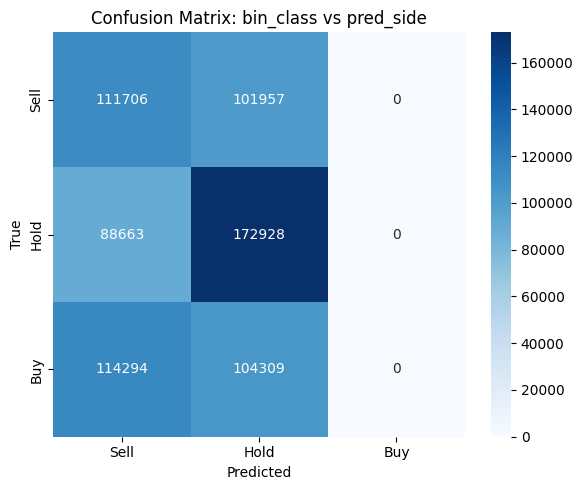

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = combined["bin_class"].astype(int)
y_pred = combined["pred_side"].astype(int)

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
labels = ["Sell", "Hold", "Buy"]

# 繪圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: bin_class vs pred_side")
plt.tight_layout()
plt.show()

## Apply Triple Barrier
We use daily volatility to calculate TP/SL, and we set our T1 as 1day

In [31]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd

def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out


def parallel_apply(func, items, num_threads=4, **kwargs):
    def worker(molecule):
        return func(molecule=molecule, **kwargs)

    chunks = np.array_split(items, num_threads)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(worker, chunks))

    return pd.concat(results).sort_index()


def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=4, t1=False, side=None):
    # Step 1: Filter targets
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    # Step 2: Set vertical barrier (t1)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)

    # Step 3: Build events DataFrame
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])

    # Step 4: Apply barriers in parallel
    df0 = parallel_apply(
        func=applyPtSlOnT1,
        items=events.index,
        num_threads=numThreads,
        close=close,
        events=events,
        ptSl=ptSl_
    )

    # Step 5: Choose the first touched barrier
    events['t1'] = df0.dropna(how='all').min(axis=1)
    if side is None:
        events = events.drop('side', axis=1)
    return events


In [42]:
%%time
events = getEvents(
    df['close'], 
    t_events, 
    [1, 1], 
    labels_df.trgt, 
    0, 
    8, 
    t1=labels_df.t1, 
    side=combined.pred_side
)

CPU times: user 3min 38s, sys: 25 s, total: 4min 3s
Wall time: 3min 24s


In [43]:
events

,t1,trgt,side
timestamp,,,
2020-01-02 05:04:42.580,2020-01-02 05:27:05.037,0.000098,0.0
2020-01-02 05:27:05.037,2020-01-02 05:46:44.205,0.000108,0.0
2020-01-02 05:46:44.205,2020-01-02 05:56:05.860,0.000105,0.0
2020-01-02 05:56:05.860,2020-01-02 06:34:27.540,0.000117,0.0
2020-01-02 06:52:54.354,2020-01-02 07:00:01.238,0.000092,0.0
...,...,...,...
2024-12-30 23:32:26.048,2024-12-30 23:34:02.941,0.000171,0.0
2024-12-30 23:34:02.941,2024-12-30 23:40:27.389,0.000223,0.0
2024-12-30 23:38:17.708,2024-12-30 23:43:02.192,0.000192,0.0


In [37]:
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[
        events_.index] - 1
    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])

    if 'side' not in events_:
        # only applies when not meta-labeling.
        # to update bin to 0 when vertical barrier is touched, we need the
        # original vertical barrier series since the events['t1'] is the time
        # of first touch of any barrier and not the vertical barrier
        # specifically. The index of the intersection of the vertical barrier
        # values and the events['t1'] values indicate which bin labels needs
        # to be turned to 0.
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.

    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

In [40]:
labels = getBins(events, close=df['close'], t1=combined.t1)
labels

,ret,bin
timestamp,,
2020-01-02 05:04:42.580,-0.0,0.0
2020-01-02 05:27:05.037,0.0,0.0
2020-01-02 05:46:44.205,-0.0,0.0
2020-01-02 05:56:05.860,-0.0,0.0
2020-01-02 06:52:54.354,-0.0,0.0
...,...,...
2024-12-30 23:32:26.048,-0.0,0.0
2024-12-30 23:34:02.941,0.0,0.0
2024-12-30 23:38:17.708,0.0,0.0


In [41]:
labels.bin.value_counts()

bin
0.0    502601
1.0    191256
Name: count, dtype: int64

In [ ]:
labeled_events = events.join(labels, how='inner')
labeled_events

## Save events to disk

In [ ]:
labeled_events.to_pickle(LABEL_FILE_PATH)